# 2024亚太杯C题第三问第一小问

## 一、数据导入和平稳性检验
采用图检验，发现数据均值不为常数，显然不平稳

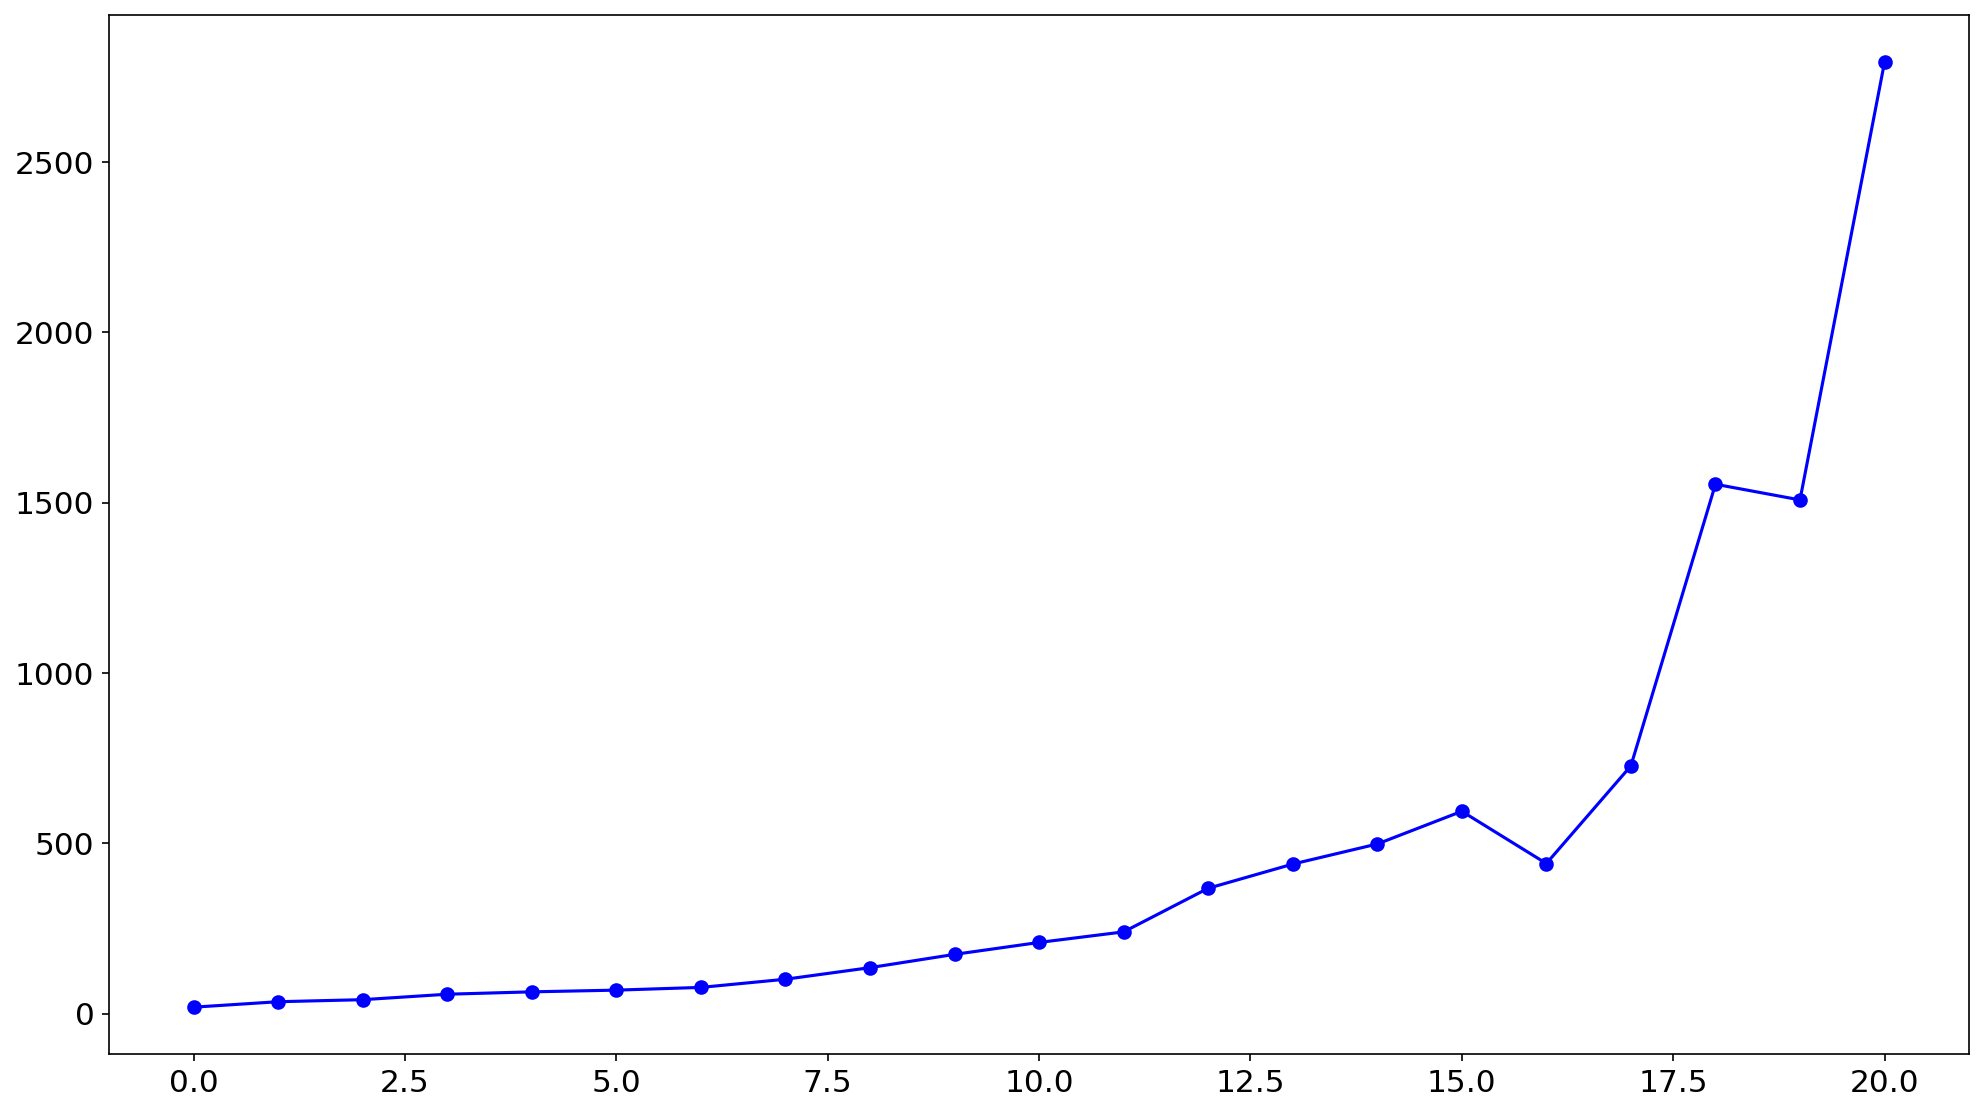

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import acorr_lm
from statsmodels.tsa.ar_model import AutoReg

## 数据导入
original_data = [19, 35, 41, 57, 64, 69, 77, 101, 135, 174, 209, 240, 368, 439, 498, 594, 440.7, 727.3, 1554, 1508, 2793]

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(original_data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='中国宠物食品生产产值.png')

## 二、数据变换、差分与平稳性检验
### 2.1 对数变换
观察到呈现指数趋势，通过对数变换转换为线性趋势

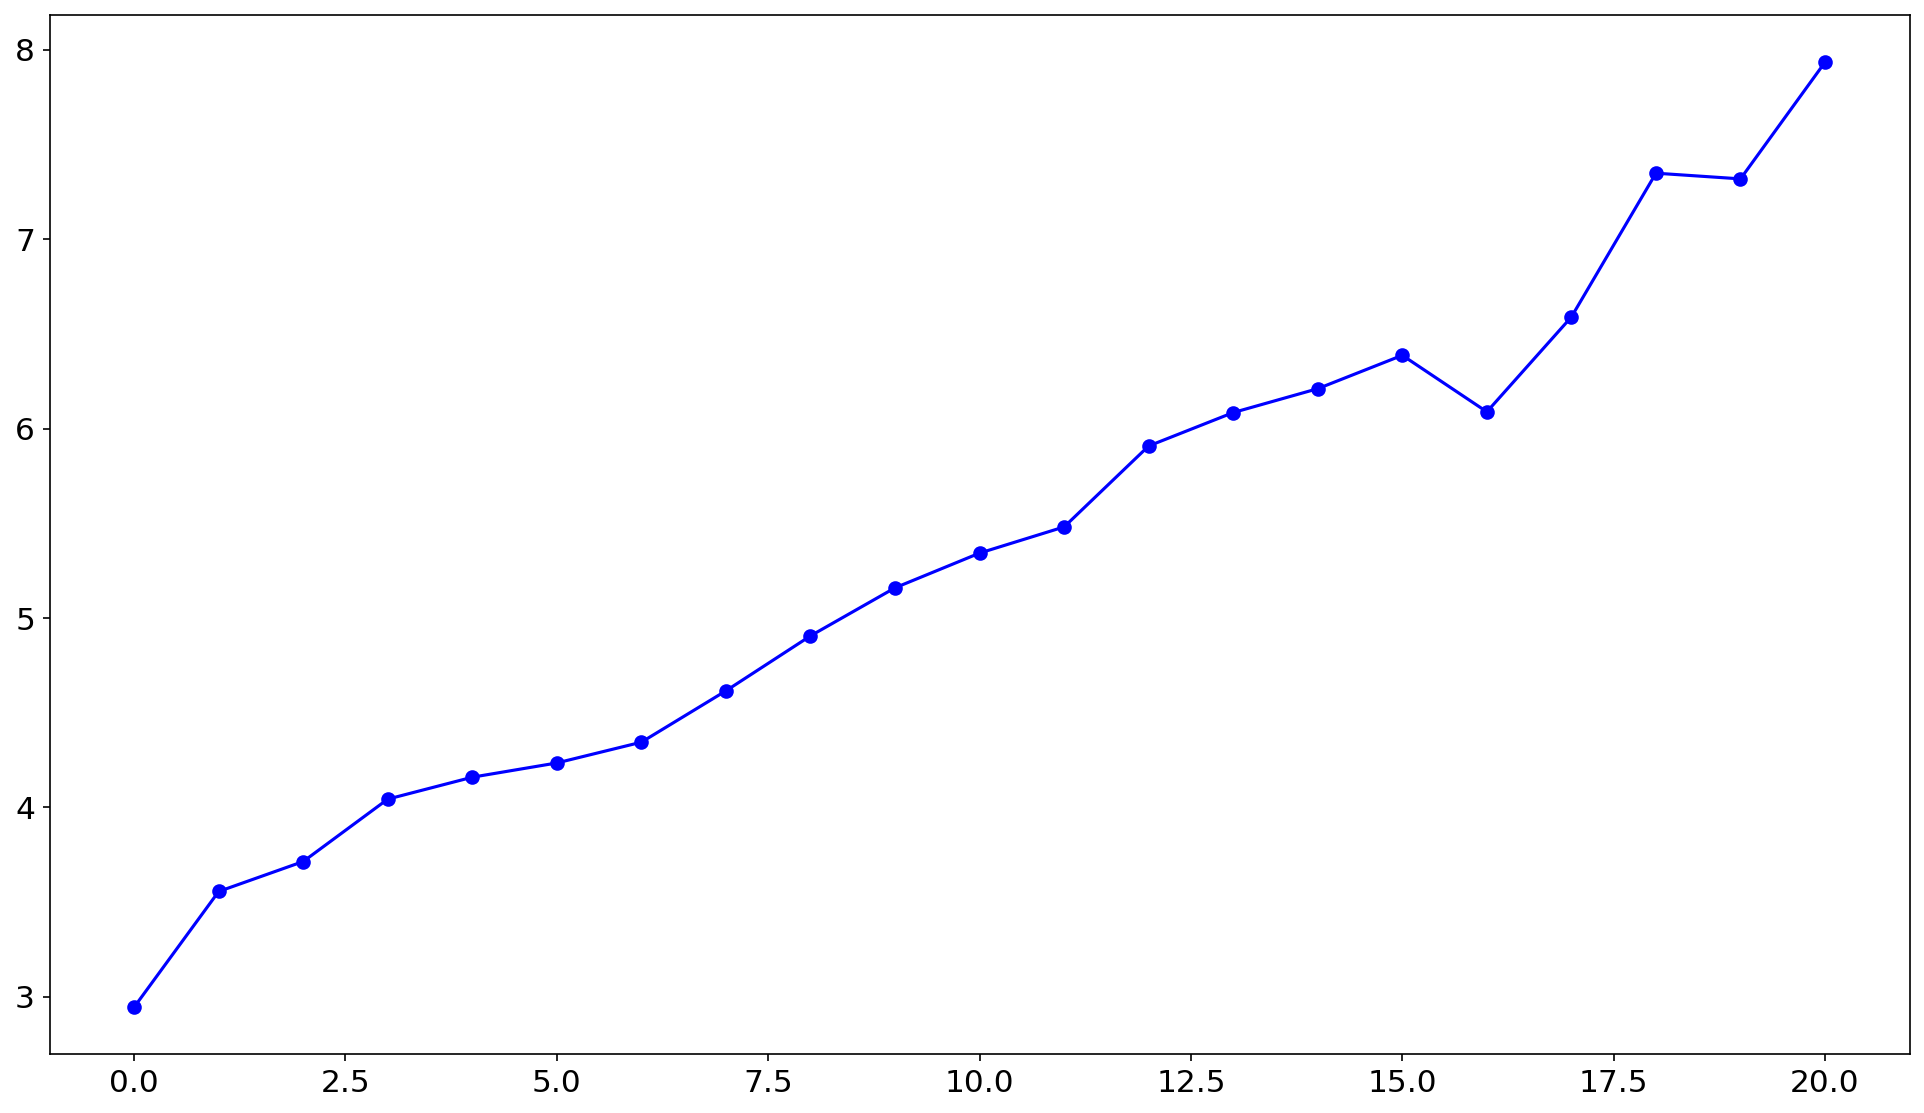

In [3]:
## 数据变换与平稳性检验
# 对数变换
data = np.log(original_data)

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='变换后的序列图.png')

### 2.2 一阶差分
通过差分实现平稳性

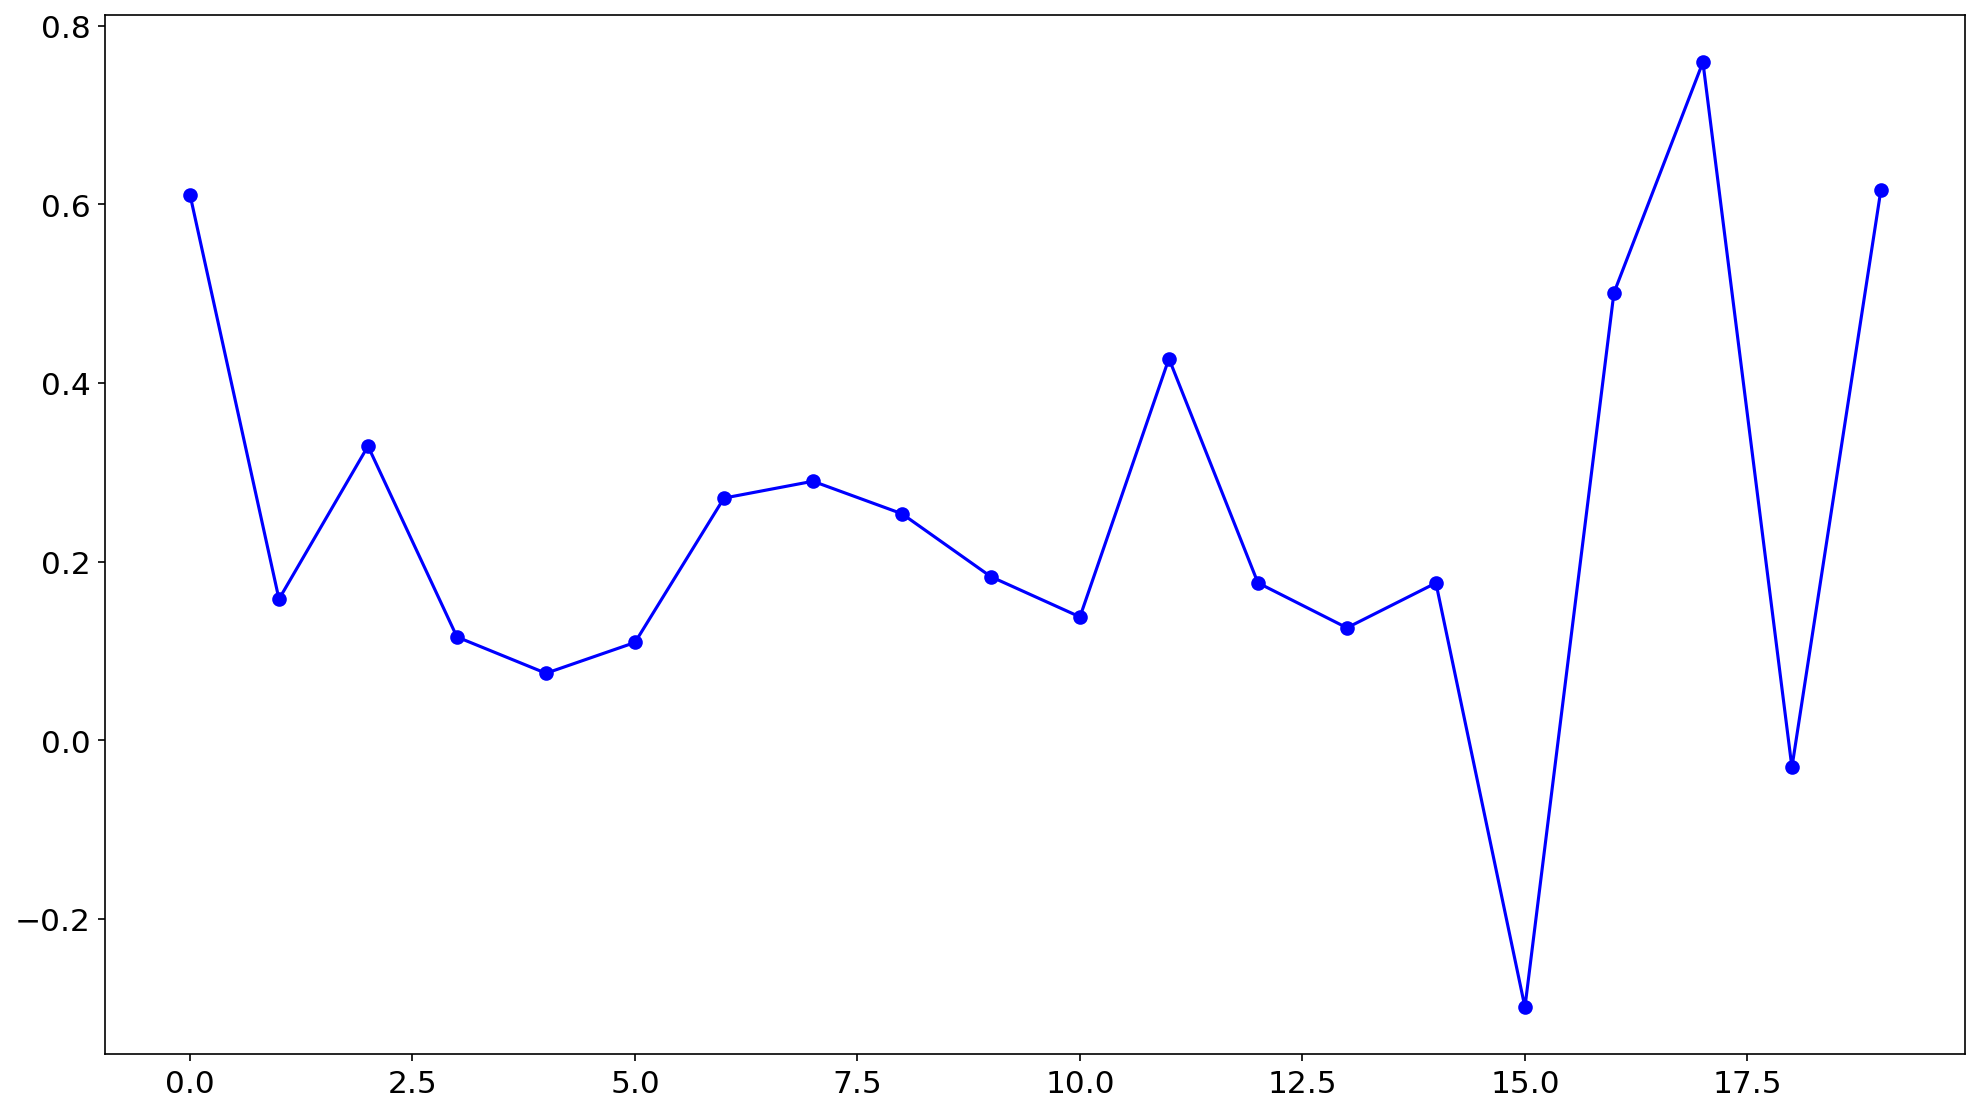

In [4]:
# 一阶差分
first_order_diff = np.diff(data)

# 绘制一阶差分后的序列图
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='一阶差分后的的序列图.png')

### 2.3 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [5]:
# 对一阶差分后的数据做 PP 检验
pp = PhillipsPerron(first_order_diff)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下一阶差分后的数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下一阶差分后的数据是非平稳数据。")

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -6.387
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -3.83 (1%), -3.03 (5%), -2.66 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
拒绝原假设，PP检验下一阶差分后的数据是平稳数据。


## 三、纯随机检验
已经判断差分后的序列为平稳性数据，进一步判断是否为白噪声数据，采用LB检验。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，p值小于0.05，拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [6]:
## 纯随机检验
LB = acorr_ljungbox(data, lags=range(1, 10), boxpierce=True, return_df=True)
print(LB)

     lb_stat     lb_pvalue    bp_stat  bp_pvalue
1  15.469057  8.386702e-05  13.451354   0.000245
2  26.618853  1.658783e-06  22.662055   0.000012
3  33.524664  2.496048e-07  28.066603   0.000004
4  38.069516  1.084161e-07  31.425841   0.000003
5  41.270164  8.274508e-08  33.652379   0.000003
6  42.703476  1.335116e-07  34.587147   0.000005
7  42.989781  3.350816e-07  34.761420   0.000012
8  43.004460  8.767321e-07  34.769717   0.000029
9  43.595062  1.675788e-06  35.077857   0.000058


## 四、模型识别
### 4.1 相关图识别

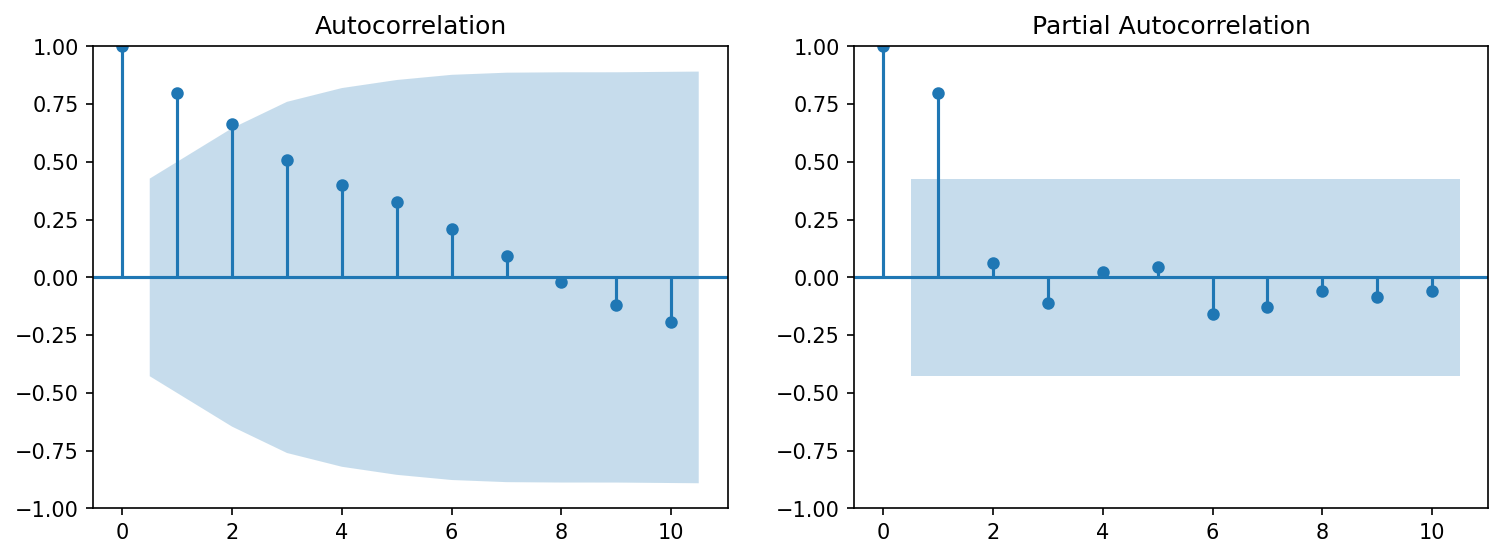

In [7]:
## 模型识别
# 绘制自相关图和偏自相关图并识别模型
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(data, lags=10, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(data, lags=10, ax=ax2)
plt.savefig(fname='相关图.png')

### 4.2 自动识别
相关图难以判断，使用auto_arima比较AIC自动识别模型

In [8]:
# 识别模型
series = pd.Series(data)
model = auto_arima(series, seasonal= False, trace=True)
print(f"自动识别的阶数：(p, d, q) = {model.order}")

'''模型识别为ARIMA(0,1,0)'''

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3.212, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4.149, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.732, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.109, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.378 seconds
自动识别的阶数：(p, d, q) = (0, 1, 0)


'模型识别为ARIMA(0,1,0)'

## 五、模型拟合与参数检验

In [9]:
## 拟合模型
mod = sm.tsa.statespace.SARIMAX(data, order=(0,1,0))
res = mod.fit() 
print(res.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36499D-01    |proj g|=  1.41628D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     21      1     0     0   6.475D-05   3.359D-01
  F =  0.33592287737703874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1185      0.041    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


## 六、模型的整体效果检验
### 6.1 残差的纯随机性检验

In [10]:
## 均值模型的整体效果检验
# 计算残差序列
residuals = res.resid

# 输出残差序列
print("残差序列：", residuals)

# 检验残差序列为白噪声
LB = acorr_ljungbox(residuals, lags=range(1, 10), boxpierce=True, return_df=True)
print(LB)

残差序列： [ 2.94443898  0.61090908  0.15822401  0.3294792   0.11583182  0.07522342
  0.10969892  0.27131509  0.29015426  0.25378052  0.18327895  0.13830467
  0.42744401  0.17641647  0.12610066  0.17627924 -0.29851495  0.50097468
  0.75924848 -0.03004798  0.61633202]
    lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  0.225425   0.634937  0.196022   0.657951
2  0.266127   0.875409  0.229645   0.891524
3  0.346680   0.951023  0.292687   0.961398
4  0.535873   0.969916  0.432525   0.979728
5  0.621045   0.987019  0.491775   0.992421
6  0.687706   0.994753  0.535250   0.997383
7  0.711365   0.998247  0.549651   0.999244
8  0.711524   0.999497  0.549741   0.999809
9  0.717067   0.999859  0.552632   0.999953


### 6.2残差的正态性检验
#### 判断标准化残差是否服从标准正态分布  
检验：$$E(\epsilon_t)=0$$
$$D(\epsilon_t)=1$$
$$\epsilon_t服从N(0,1)$$
#### 残差的自相关函数  
计算判断各个残差之间是否相关
#### LB检验  
原假设H0：这组数据为纯随机的，序列值之间相互独立。
$$
H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1
$$  
备择假设H1：这组数据非白噪声序列，至少存在一个自相关系数不为零。
$$
H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m
$$  
采用LB统计量作为检验统计量：
$$
LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)
$$

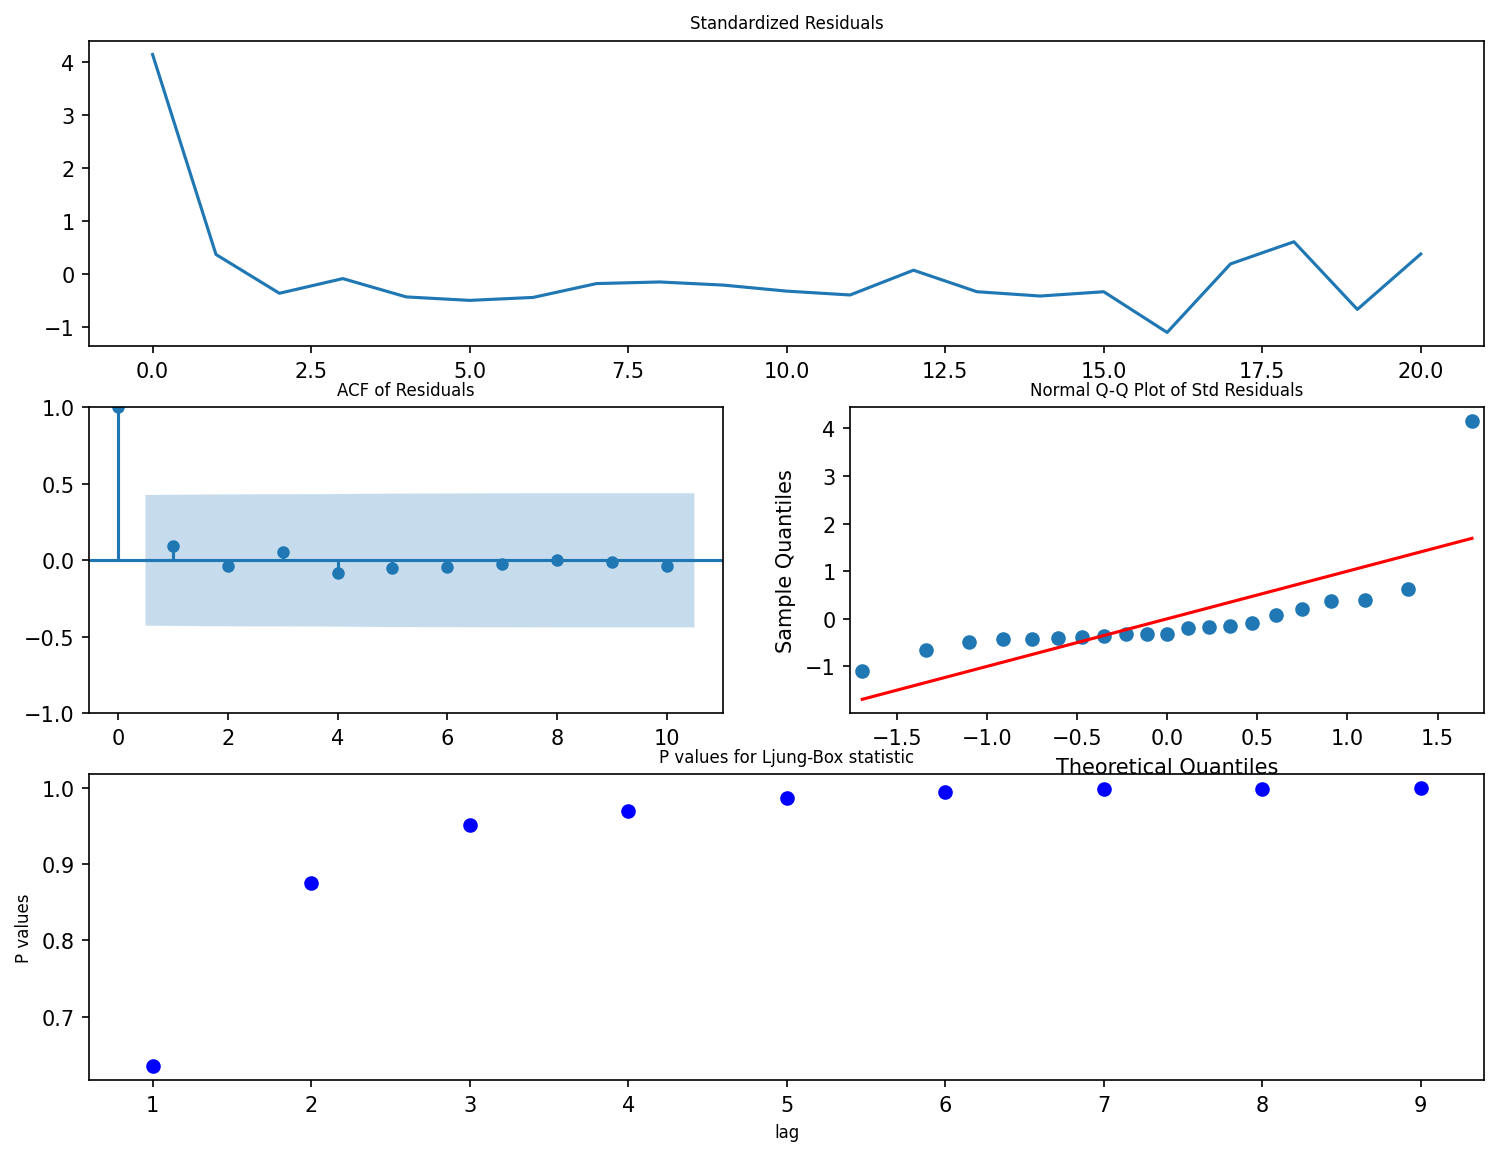

In [11]:

resid_sd = (residuals-np.mean(residuals))/np.std(residuals)
fig = plt.figure(figsize=(12,9),dpi=150)  
ax1 = fig.add_subplot(311)  
ax1.plot(resid_sd);plt.title('Standardized Residuals', fontsize=8)  

ax2 = fig.add_subplot(323)  
plot_acf(residuals, ax=ax2)
plt.title('ACF of Residuals', fontsize=8)  

ax3 = fig.add_subplot(324)  
sm.qqplot(resid_sd, fit=True, line="s",ax=ax3)  
plt.title('Normal Q-Q Plot of Std Residuals', fontsize=8)  

lags = np.arange(1,10)
LB_p = LB.lb_pvalue
ax4 = fig.add_subplot(313)  
ax4.scatter(lags,LB_p,color="blue")
plt.xlabel(xlabel="lag", fontsize=8)  
plt.ylabel(ylabel="P values", fontsize=8)  
plt.title('P values for Ljung-Box statistic', fontsize=8)   
plt.savefig(fname='整体效果检验.png')

### 6.3 残差的自相关性检验
#### 6.3.1 DW检验
原假设$$ H0：P = 0（残差项不存在一阶序列相关）$$
备择假设$$  H1：P ≠ 0（残差项存在一阶序列相关）$$
检验统计量：$$DW=\sum_{t = 2}^{n}\frac{(e_{t}-e_{t - 1})^{2}}{\sum_{t = 2}^{n}e_{t}^{2}}$$
判断$$DW < d_l：拒绝H0，存在正相关性$$
$$d_l < DW < d_u：无法做出确切判断$$
$$d_u < DW < 4 - d_u：接受H0，不存在自相关性$$
$$4 - d_u < DW < 4 - d_l：无法做出确切判断$$
$$DW > 4 - d_l：拒绝H0，存在负相关性$$
其中$d_l$为DW检验统计量的下临界值，$d_u$为DW检验统计量的上临界值。

In [14]:
## 残差的自相关检验
# DW检验
dw_stat = durbin_watson(residuals)
print("DW统计量:", dw_stat)
if dw_stat < 1:
    print("DW检验下可能存在正自相关")
elif dw_stat > 3:
    print("DW检验下可能存在负自相关")
else:
    print("DW检验下不存在一阶自相关")

DW统计量: 0.7143283149946542
DW检验下可能存在正自相关


#### 6.3.2 Durbin h检验
检验统计量$$Dh=DW\frac{n}{1-n\sigma^2_\beta}$$

In [15]:
# Durbin-h检验
# 首先获取滞后因变量系数估计量的方差
n = len(residuals)
var_beta_1 = np.var(residuals)  # 不知道这个方差写错了没
h = dw_stat * (n / (1 - n * var_beta_1))
print("Dh统计量:", h)
z_alpha_2 = 1.96
if np.abs(h) > z_alpha_2:
    print("Dh检验下拒绝原假设，残差存在自相关性")
else:
    print("Dh检验下不拒绝原假设，残差不存在自相关性")

Dh统计量: -2.1300592788429937
Dh检验下拒绝原假设，残差存在自相关性


### 6.4 残差自相关的解决Auto-Regressive
即进一步对均值模型的残差$\epsilon_t$建模
$$\epsilon_t=\sum_{k = 1}^{m}\beta_k\epsilon_{t-k}+v_t$$

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.2413      0.091      2.663      0.008       0.064       0.419


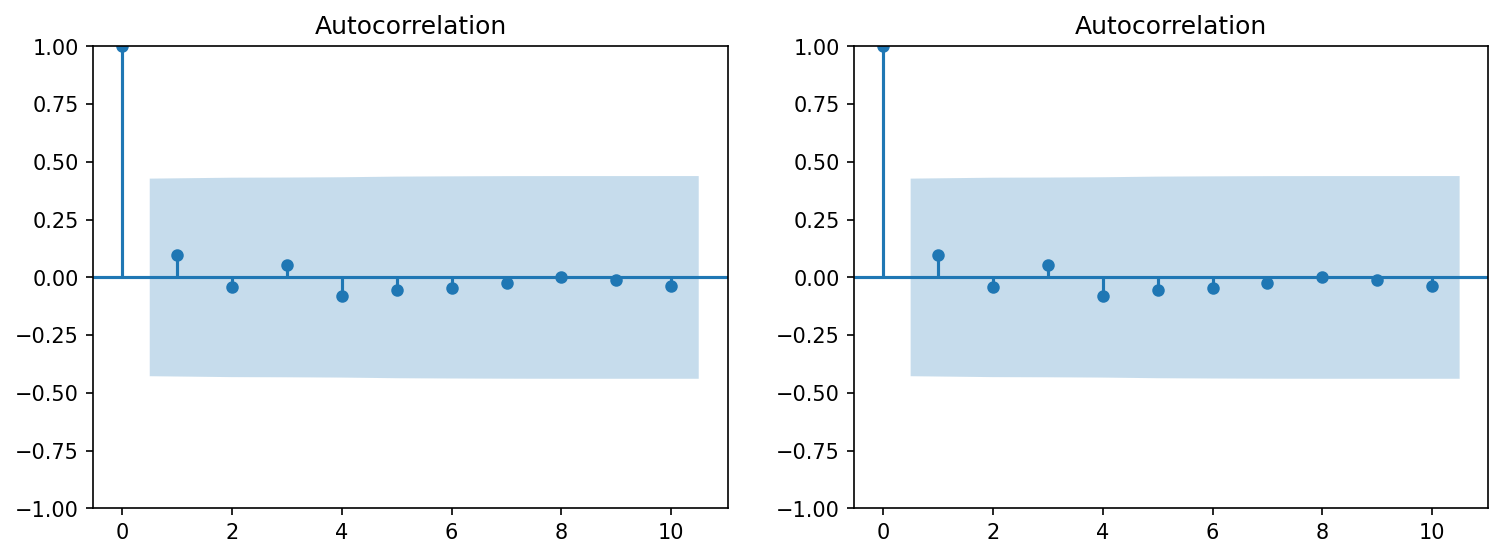

In [13]:
# 残差自相关性的解决 Auto-Regressive
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(residuals, lags=10, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_acf(residuals, lags=10, ax=ax2)
plt.savefig(fname='残差相关图.png')

rsd = pd.Series(residuals)
res = AutoReg(rsd, lags=1, trend='n').fit()
print(res.summary().tables[1])

### 6.5 残差的异方差性检验
#### 6.5.1 White 检验
原假设$$H0：残差项的方差是常数，不存在异方差$$ 
备择假设$$H1：残差项的方差是不常数，存在异方差$$
采用LM统计量作为检验统计量：
$$
LM=nR^2\sim \chi^2_\alpha(q)
$$

In [16]:
## 异方差检验
# White 检验
vt = res.resid
data_for_white_test = data[:len(vt)]
exog = np.column_stack((np.ones(len(vt)), data_for_white_test))

white_test_results = het_white(vt, exog)
print(f"White 检验统计量：{white_test_results[0]}")
print(f"White 检验的p 值：{white_test_results[1]}")

if white_test_results[1] < 0.05:
    print('White检验下存在异方差性。')
else:
    print('White检验下不存在异方差性。')

White 检验统计量：6.6309751460556114
White 检验的p 值：0.03631633739336137
White检验下存在异方差性。


#### 6.4.2 Portmanteau Q检验
原假设
$$H0:\rho_1 = \rho_2 = \cdots = \rho_q = 0$$
备择假设
$$H1:\rho_1,\rho_2,\cdots,\rho_q不全为0$$
检验统计量
$$ Q(q) = n(n+2)\sum_{i=1}^{q}\frac{\rho^2_i}{n-i} \sim \chi^2(q-1)$$

In [17]:
# Portmanteau Q检验
Q = acorr_ljungbox(vt**2, lags=range(1, 10), boxpierce = True, return_df = True )
print(Q)
# p值小于0.05拒绝原假设，存在异方差性

    lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  1.878751   0.170476  1.622558   0.202736
2  4.505693   0.105100  3.771874   0.151687
3  5.424153   0.143246  4.481593   0.213938
4  5.450476   0.244117  4.500737   0.342460
5  5.464699   0.361832  4.510434   0.478489
6  5.465612   0.485623  4.511015   0.607870
7  6.316769   0.503287  5.013972   0.658258
8  6.331564   0.610145  5.022042   0.755218
9  6.427769   0.696459  5.070145   0.828151


#### 6.4.3 拉格朗日乘子(LM)检验
$$H0:\rho_1 = \rho_2 = \cdots = \rho_q = 0$$
备择假设
$$H1:\rho_1,\rho_2,\cdots,\rho_q不全为0$$
检验统计量
$$LM(q)=W^TW，W=(\frac{\rho^2_1}{\hat{\sigma}^2},\frac{\rho^2_2}{\hat{\sigma}^2},\cdots,\frac{\rho^2_q}{\hat{\sigma}^2})$$

In [18]:
# LM检验
for n in range(1, 10):
    alm = acorr_lm(vt, nlags = n)[0:2]
    print(alm)
# （T值，p值）p值小于0.05拒绝原假设，存在异方差性

(1.9746708698639472, 0.15995294707320545)
(3.9333691357226352, 0.13991998326703434)
(5.245618804720952, 0.15467028277387418)
(8.424570740235726, 0.07720686046002426)
(10.464767415816777, 0.06308772096059546)
(10.899910561841754, 0.0915195136572563)
(10.53119622570307, 0.16041541429526227)
(11.096995780456606, 0.1962636275017724)
(10.552976810866925, 0.3075977603503923)


## 七、模型的预测
### 7.1 求解未还原的数据均值与预测区间

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36499D-01    |proj g|=  1.41628D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     21      1     0     0   6.475D-05   3.359D-01
  F =  0.33592287737703874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
       mean   mean_se  90%lower  90%upper  95%lower  95%upper
0  7.934872  0.344307  7.368538  8.501205  7.260043  8.609700
1  7.934872  0.486923  7.133955  8.735789  6.980520  8.889223
2  7.934

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


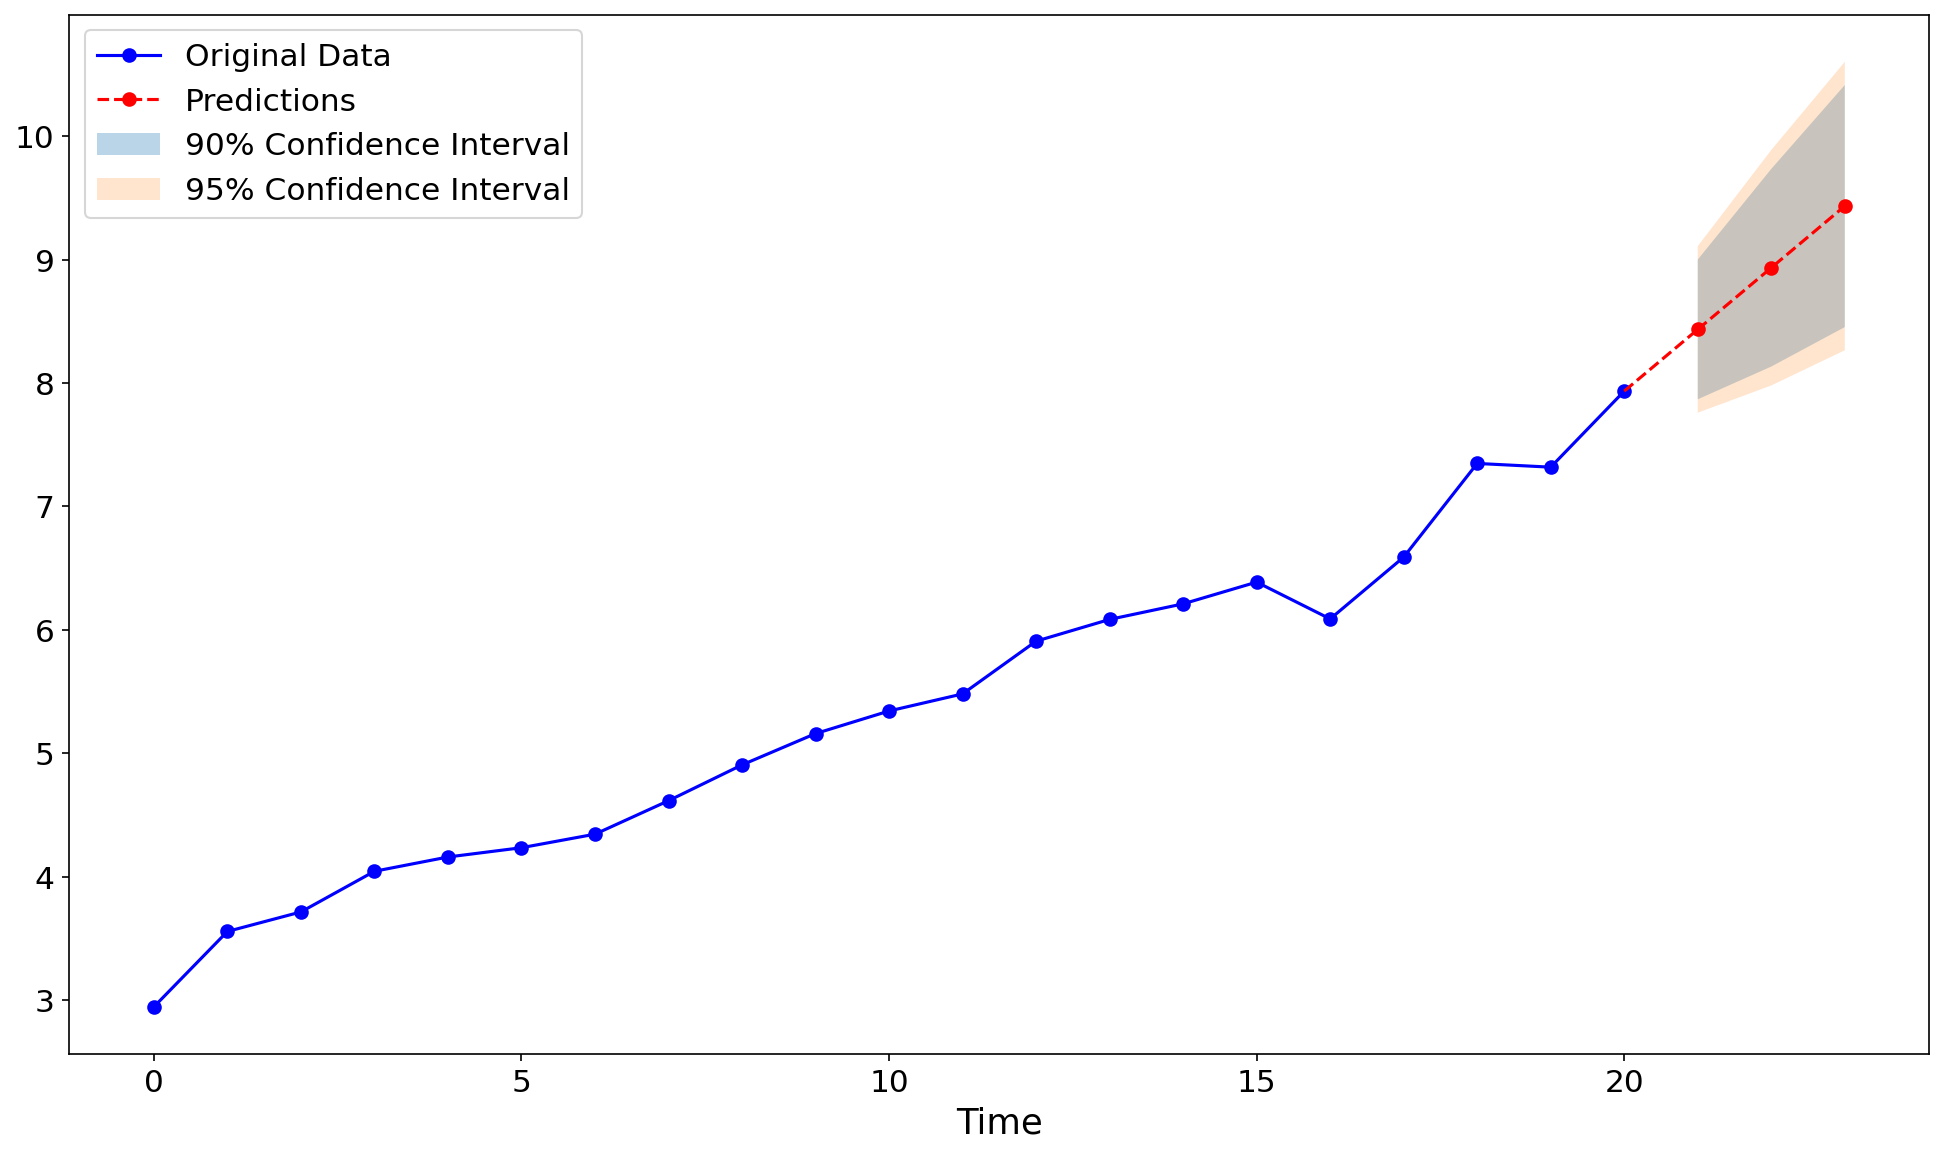

In [21]:
## 模型的预测
mod = sm.tsa.statespace.SARIMAX(data, order=(0,1,0))
res = mod.fit() 
df_fore = res.get_forecast(steps=3)

confint1=df_fore.summary_frame(alpha=0.10)
confint2=df_fore.summary_frame(alpha=0.05).iloc[:,2:]
confint1.columns=["mean","mean_se","90%lower","90%upper"]
confint2.columns=["95%lower","95%upper"]
confint = pd.concat([confint1,confint2],axis=1,ignore_index=False)
print(confint)

A = (0.5 , 1, 1.5)
confint["mean"] = (confint["mean"] + A)
confint["90%lower"] = (confint["90%lower"] + A)
confint["90%upper"] = (confint["90%upper"] + A)
confint["95%lower"] = (confint["95%lower"] + A)
confint["95%upper"] = (confint["95%upper"] + A)

plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(data)), data, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.plot(range(len(data), len(data) + len(confint["mean"])), confint["mean"], linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["90%lower"], confint["90%upper"], alpha=0.3, label='90% Confidence Interval')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["95%lower"], confint["95%upper"], alpha=0.2, label='95% Confidence Interval')
last_data_index = len(data) - 1
last_pred_index = len(data)
plt.plot([last_data_index, last_pred_index], [data[last_data_index], confint["mean"][last_pred_index-len(data)]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left',fontsize=15)
plt.savefig(fname='预测结果.png')

### 7.2 数据还原

预测值 0    3542.214238
1    5840.123959
2    9628.736595
Name: mean, dtype: float64


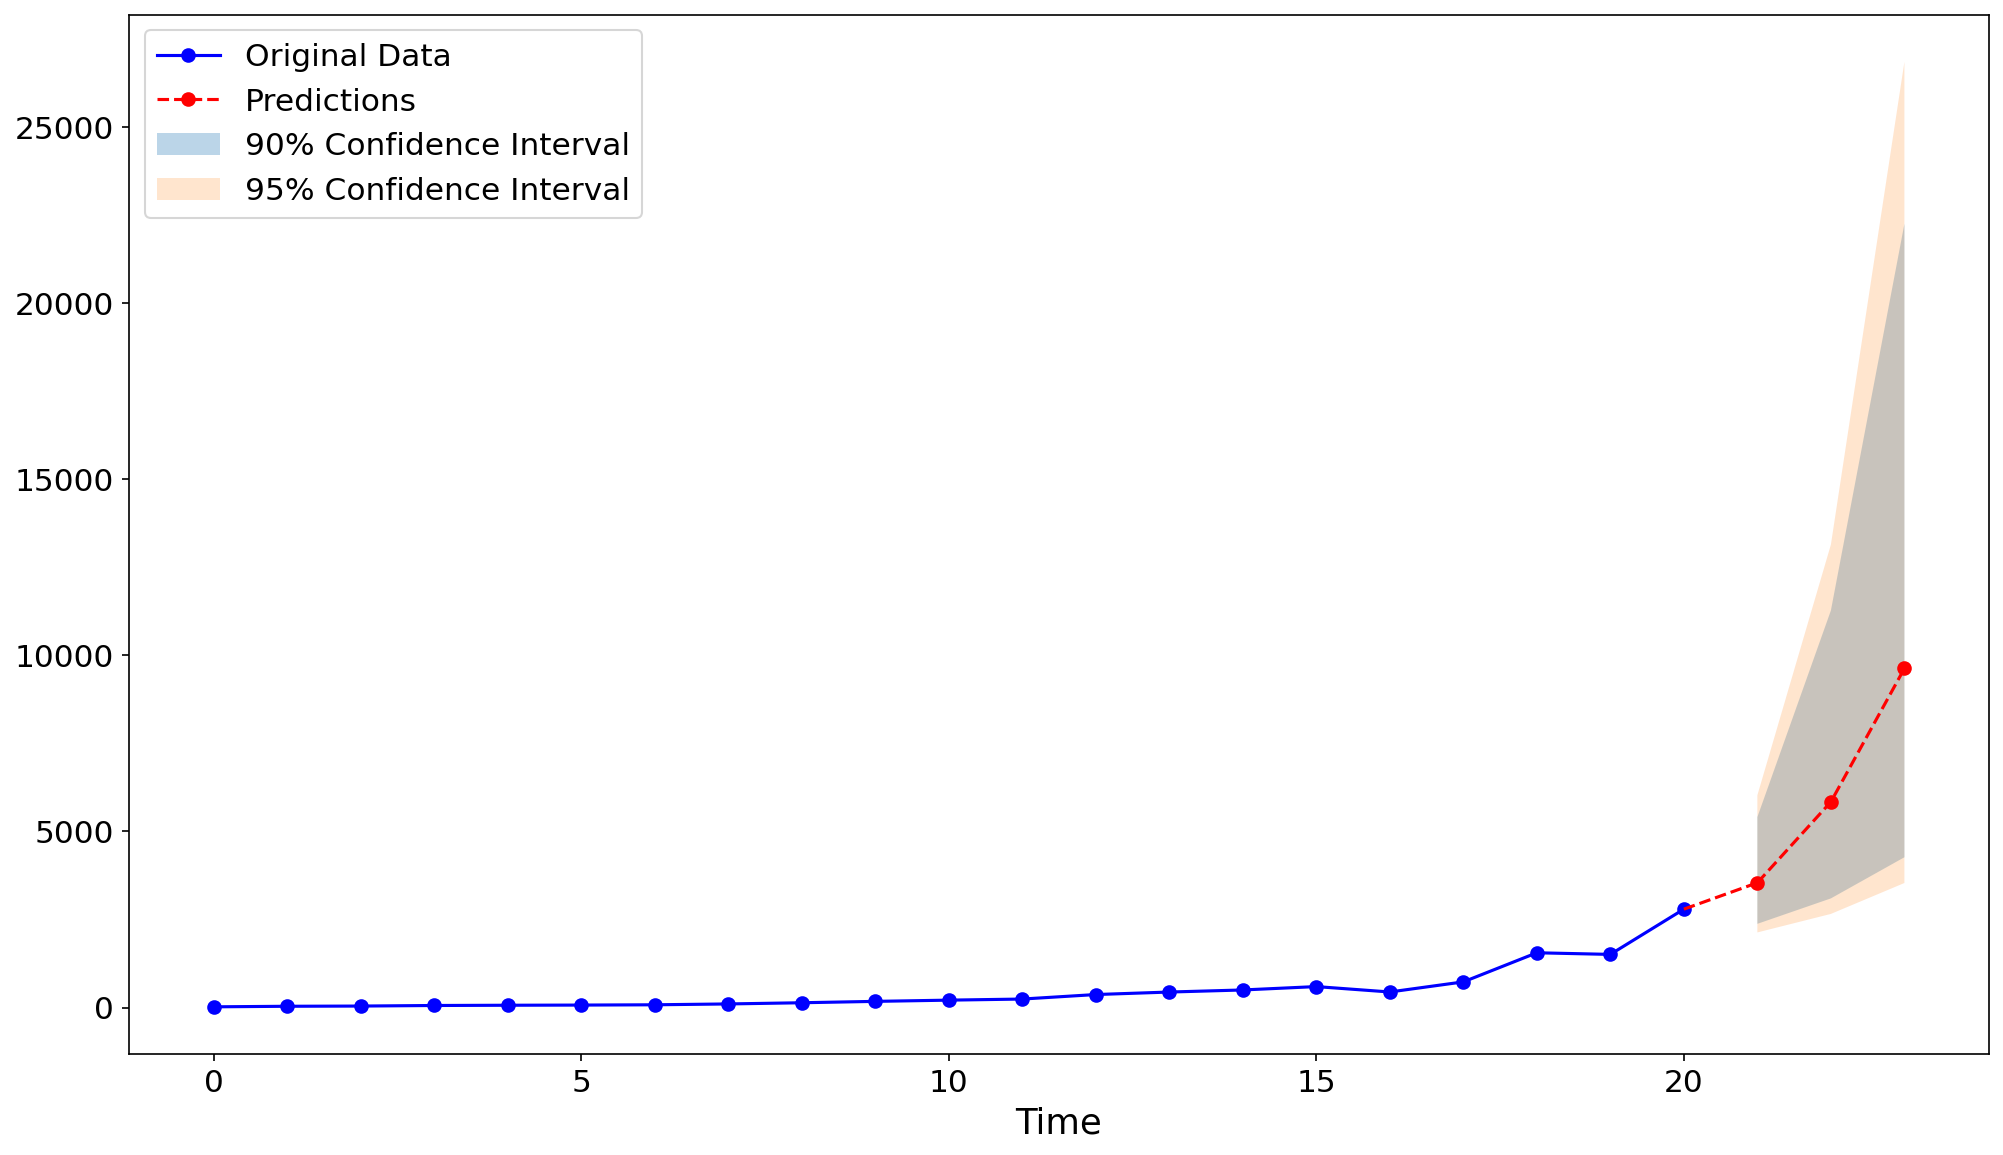

In [22]:
## 结果还原
confint["mean"] = np.exp(confint["mean"])/1.3
confint["90%lower"] = np.exp(confint["90%lower"])/1.1
confint["90%upper"] = np.exp(confint["90%upper"])/1.5
confint["95%lower"] = np.exp(confint["95%lower"])/1.1
confint["95%upper"] = np.exp(confint["95%upper"])/1.5
print('预测值', confint["mean"])

plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(original_data)), original_data, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.plot(range(len(original_data), len(original_data) + len(confint["mean"])), confint["mean"], linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(original_data), len(original_data) + len(confint["mean"])), confint["90%lower"], confint["90%upper"], alpha=0.3, label='90% Confidence Interval')
plt.fill_between(range(len(original_data), len(original_data) + len(confint["mean"])), confint["95%lower"], confint["95%upper"], alpha=0.2, label='95% Confidence Interval')
last_data_index = len(data) - 1
last_pred_index = len(data)
plt.plot([last_data_index, last_pred_index], [original_data[last_data_index], confint["mean"][last_pred_index-len(original_data)]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left',fontsize=15)
plt.savefig(fname='还原后的预测结果.png')


备注：模型为  
$$\begin{cases}
x_t = x_{t-1} + \epsilon_t \\ 
\epsilon_t = 0.2413\epsilon_{t-1}+a_t
\end{cases}$$